In [2]:
import cv2
import os


In [3]:
#The path to the omniglot data
root_path = "D:/Python Codes/Final-Model-Backend"
train_path = os.path.join(root_path,'Dataset4/training/')
validation_path =os.path.join(root_path,'Dataset4/validation/')
model_save_path=os.path.join(root_path,'transfer_learning_siamese_model_sequential2.h5')
INIT_WEIGHTS = os.path.join(root_path, 'init_weights2.hdf5')
CHECKPOINTED_WEIGHTS = os.path.join(root_path, 'checkpointed_weights2.hdf5')

In [ ]:
face_id=0
user_folder_id=0
# path = 'D:/Python Codes/Final-Model-Backend/Dataset3/validation/'
user_folder_id=len(list(os.walk(validation_path)))
cam = cv2.VideoCapture(1)
cam.set(3, 640) # set video width
cam.set(4, 480) # set video height
face_detector = cv2.CascadeClassifier('haarcascade_face.xml')
# For each person, enter one numeric face id
folder_path=os.path.join(validation_path,('Student-'+str(user_folder_id)))
# if user_folder_id==2 and os.path.exists(folder_path):
# os.remove(folder_path)
os.mkdir(folder_path)
user_folder_id+=1
# else:
#         os.mkdir(folder_path)
#         user_folder_id+=1
face_id+=1
print("\n [INFO] Initializing face capture. Look the camera and wait ...")
# Initialize individual sampling face count
count = 0

while(True):
    ret, img = cam.read()
    img = cv2.flip(img, 1) # flip video image vertically
# #     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     img = cv2.cvtColor (img, cv2.COLOR_BGR2GRAY)
    faces = face_detector.detectMultiScale(img,     
        scaleFactor=1.3,
        minNeighbors=5,     
        minSize=(30, 30))
    for (x,y,w,h) in faces:
        cv2.rectangle(img, (x,y), (x+w,y+(h+5)), (255,0,0), 2)     
        count += 1
        roi=img[y:y+(h+5),x:x+w]
        # Save the captred image into the datasets folder
        cv2.imwrite(os.path.join(folder_path,('Student-'+ str(user_folder_id) + '-' +  
                    str(count) + ".png")),roi)
        
        
        cv2.imshow('image', img)
       
    k = cv2.waitKey(100) & 0xff # Press 'ESC' for exiting video
    if k == 27:
        break
#         face_id+=1
    elif count >= 60: # Take 30 face sample and stop video
        break
#         face_id+=1
# Do a bit of cleanup
print("\n [INFO] Exiting Program and cleanup stuff")
cam.release()
cv2.destroyAllWindows()

In [62]:
import sys
import numpy as np
import imageio
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import keras 
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [63]:
import random
random.seed(2) # Python
np.random.seed(1) #numpy
# from tensorflow import set_random_seed
# set_random_seed(3) # Tensorflow
import tensorflow as tf
tf.random.set_seed(3)

In [64]:

def load_image(path, n = 0):
    X = []
    
    #Load every srud seperately and place that in one tensor
    for student in os.listdir(path):
#         print("Loading student: " + student)
        student_path = os.path.join(path, student)
       
        category_images = []
            
        if not os.path.isdir(student_path):
                continue
            
            #Read evey image with in the directory
        for filename in os.listdir(student_path):
                image_path = os.path.join(student_path, filename)
                image = imageio.imread(image_path)
                width = 105
                height = 105 # keep original height
                dim = (height,width)
 
                # resize image
                image = cv2.resize(image, dim)
                image=cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
                image= np.expand_dims(image, axis=0)
#                 print(image_path)
                #Image preprocessing
                image = image/255
                image = 1 - image
                
                X.append(image)
                
        
    X = np.stack(X)
    return X

In [65]:
print("Loading Training Set")
Xtrain=[]
Xtrain = load_image(train_path)
print(Xtrain.shape)


Loading Training Set
(1596, 1, 105, 105)


In [66]:
print("Now loading evaluation set")
Xval=[]
Xval = load_image(validation_path)
print(Xval.shape)


Now loading evaluation set
(120, 1, 105, 105)


In [67]:
def get_batch(data, batch_size):
    n_classes, n_examples, h, w = data.shape
    
    pairs = [np.zeros((batch_size, 1, h, w)) for i in range(2)]
    
    targets = np.zeros((batch_size,))
    targets[batch_size//2:] = 1
    
    categories = np.random.choice(n_classes, size = (batch_size), replace = False)
    
    for i in range(batch_size):
        category = categories[i]
        
        idx1 = np.random.randint(0, n_examples)
        pairs[0][i,:,:,:] = data[category, idx1].reshape(1, h,w)
        idx2 = np.random.randint(0, n_examples)
        
        if targets[i] == 0:
            category_2 = category
        else:
            category_2 = (category + np.random.randint(1, n_classes)) % n_classes
 
        
        pairs[1][i,:,:,:] = data[category_2, idx2].reshape(1, h, w)
        
    return pairs, targets
        



In [68]:
def generate(data,batch_size):
        """a generator for batches, so model.fit_generator can be used. """
        while True:
            pairs, targets = get_batch(data,batch_size)
            yield (pairs, targets)    


 

In [69]:
def make_oneshot_task(N,data):
        """Create pairs of test image, support set for testing N way one-shot learning. """
        n_classes, n_examples, w, h = data.shape
        indices = np.random.randint(0,n_examples,size=(N,))
        categories = np.random.choice(range(n_classes),size=(N,),replace=False)            
        true_category = categories[0]
        ex1 = np.random.randint(0, n_examples)
        ex2 = np.random.randint(0, n_examples)
        # ex1, ex2 = np.random.choice(n_examples,replace=False,size=(0,))
        test_image = np.asarray([data[true_category,ex1,:,:]]*N).reshape(N, 1, w,h)
        support_set = data[categories,indices,:,:]
        support_set[0,:,:] = data[true_category,ex2]
        support_set = support_set.reshape(N, 1, w,h)
        targets = np.zeros((N,))
        targets[0] = 1
        targets, test_image, support_set = shuffle(targets, test_image, support_set)
        pairs = [test_image,support_set]

        return pairs, targets
    

                   

In [70]:
def test_oneshot(model,N,k,data,verbose=0):
        """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
        n_correct = 0
        if verbose:
            print("Evaluating model on {} random {} way one-shot learning tasks ...".format(k,N))
        for i in range(k):
            inputs, targets = make_oneshot_task(N,data)
            probs = model.predict(inputs)
            if np.argmax(probs) == np.argmax(targets):
                n_correct+=1
        percent_correct = (100.0*n_correct / k)
        if verbose:
            print("Got an average of {}% {} way one-shot learning accuracy".format(percent_correct,N))
        return percent_correct
    


In [71]:
def train(model, epochs, verbosity):
        model.fit_generator(self.generate(batch_size),)
        

In [90]:
from keras.models import Model, load_model,Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Input, Lambda
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.merge import concatenate
from keras.optimizers import Adam
from keras.regularizers import l2

from keras import backend as K
from keras.models import Model, load_model, Sequential
from keras.layers import Input, Activation
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
import time
from keras.optimizers import RMSprop
import pickle

In [107]:
def build_base_network(input_shape):
    
    seq = Sequential()
    
    nb_filter = [11, 13]
    kernel_size =3
    
    
    #convolutional layer 1
    seq.add(Conv2D(nb_filter[0], kernel_size, kernel_size, input_shape=input_shape,
                          border_mode='valid', dim_ordering='th'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2))) 
    seq.add(Dropout(.0001))
    
    #convolutional layer 2
    seq.add(Conv2D(nb_filter[1], kernel_size, kernel_size, border_mode='valid', dim_ordering='th'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='th')) 
    seq.add(Dropout(.0001))

    #flatten 
    seq.add(Flatten())
    seq.add(Dense(128, activation='relu'))
    seq.add(Dropout(0.00001))
    seq.add(Dense(50, activation='relu'))
    return seq

In [108]:
#Contrastive Loss
def euclid_dist(input_pair):
    x, y = input_pair
    distance = K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))
    return distance

def euclid_dist_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)

def contrastive_loss(y_true, y_pred):
    margin = 1
    y_true = -1 * y_true + 1
    return K.mean((1-y_true) * K.square(y_pred) + y_true *  K.square(K.maximum(margin - y_pred, 0.0)))

def acc(y_true, y_pred):
    ones = K.ones_like(y_pred)
    return K.mean(K.equal(y_true, ones - K.clip(K.round(y_pred), 0, 1)), axis=-1)



In [109]:
input_dim =(Xtrain.shape[1:])
base_network = build_base_network(input_dim)
# print(input_dim)

img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)

# print(base_network)
feat_vecs_a = base_network(img_a)
feat_vecs_b = base_network(img_b)

distance = Lambda(euclid_dist, output_shape=euclid_dist_shape)([feat_vecs_a, feat_vecs_b])
prediction = Dense(1, activation='sigmoid')(distance)


d:\anaconda3\envs\env-conda\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(11, (3, 3), input_shape=(1, 105, 1..., padding="valid", data_format="channels_first")`
  # This is added back by InteractiveShellApp.init_path()
d:\anaconda3\envs\env-conda\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(13, (3, 3), padding="valid", data_format="channels_first")`
d:\anaconda3\envs\env-conda\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), data_format="channels_first")`


In [110]:

siamese = Model(inputs=[img_a, img_b], outputs=prediction)
    
optimizer = Adam(lr = 0.0006)
    
siamese.compile(loss=contrastive_loss, optimizer=optimizer, metrics=[acc])

siamese.summary()
os.system("rm {}".format(INIT_WEIGHTS))
siamese.save_weights(INIT_WEIGHTS)

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 1, 105, 105)  0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           (None, 1, 105, 105)  0                                            
__________________________________________________________________________________________________
sequential_12 (Sequential)      (None, 50)           2004086     input_21[0][0]                   
                                                                 input_22[0][0]                   
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, 1)            0           sequential_12[1][0]       

In [111]:
#Training loop

print("!")
evaluate_every = 1 # interval for evaluating on one-shot tasks
loss_every=5 # interval for printing loss (iterations)
batch_size = 10
n_iter = 30
N_way =31# how many classes for testing one-shot tasks>
n_val = 5 #how mahy one-shot tasks to validate on?
best = -1
inputs=[]
targets=[]
weights_path= CHECKPOINTED_WEIGHTS
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
for i in range(1, n_iter):
    (inputs,targets)=get_batch(Xtrain,batch_size)
    loss=siamese.train_on_batch(inputs,targets)
#     print(loss)
    if i % evaluate_every == 0:
        print("Time for {0} iterations: {1}".format(i, time.time()-t_start))
        val_acc = test_oneshot(siamese,N_way,n_val,Xval,verbose=True)
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc , best))
            print("Saving weights to: {0} \n".format(weights_path))
            siamese.save(weights_path)
            best=val_acc

    if i % loss_every == 0:
        print("iteration {}, training loss: {},".format(i,loss))

!
Starting training process!
-------------------------------------
Time for 1 iterations: 17.86634635925293
Evaluating model on 5 random 31 way one-shot learning tasks ...
Got an average of 100.0% 31 way one-shot learning accuracy
Current best: 100.0, previous best: -1
Saving weights to: D:/Python Codes/Final-Model-Backend\checkpointed_weights2.hdf5 

Time for 2 iterations: 24.400452613830566
Evaluating model on 5 random 31 way one-shot learning tasks ...
Got an average of 100.0% 31 way one-shot learning accuracy
Current best: 100.0, previous best: 100.0
Saving weights to: D:/Python Codes/Final-Model-Backend\checkpointed_weights2.hdf5 

Time for 3 iterations: 30.10447072982788
Evaluating model on 5 random 31 way one-shot learning tasks ...
Got an average of 100.0% 31 way one-shot learning accuracy
Current best: 100.0, previous best: 100.0
Saving weights to: D:/Python Codes/Final-Model-Backend\checkpointed_weights2.hdf5 

Time for 4 iterations: 36.20271635055542
Evaluating model on 5 ra

Got an average of 100.0% 31 way one-shot learning accuracy
Current best: 100.0, previous best: 100.0
Saving weights to: D:/Python Codes/Final-Model-Backend\checkpointed_weights2.hdf5 

Time for 29 iterations: 97.8515841960907
Evaluating model on 5 random 31 way one-shot learning tasks ...
Got an average of 100.0% 31 way one-shot learning accuracy
Current best: 100.0, previous best: 100.0
Saving weights to: D:/Python Codes/Final-Model-Backend\checkpointed_weights2.hdf5 



In [112]:

siamese.load_weights(CHECKPOINTED_WEIGHTS)
for layer in siamese.layers:
    layer.trainable = False
siamese.summary()
siamese.save(model_save_path)

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 1, 105, 105)  0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           (None, 1, 105, 105)  0                                            
__________________________________________________________________________________________________
sequential_12 (Sequential)      (None, 50)           2004086     input_21[0][0]                   
                                                                 input_22[0][0]                   
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, 1)            0           sequential_12[1][0]       

d:\anaconda3\envs\env-conda\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [113]:
import keras.losses
# keras.losses.custom_loss = 
from keras.utils.generic_utils import get_custom_objects
from keras.models import load_model
siamese_net = load_model(model_save_path, custom_objects={'contrastive_loss': contrastive_loss})
siamese_net.compile(loss=contrastive_loss, optimizer='adam', metrics=[acc])

d:\anaconda3\envs\env-conda\lib\site-packages\keras\engine\saving.py:384: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [116]:
def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0


def test_nn_accuracy(N_ways,n_trials):
    """Returns accuracy of one shot """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = make_oneshot_task(N_ways,Xval)
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials


ways = np.arange(1, 31, 1)
resume =  False
val_accs, train_accs,nn_accs = [], [], []
trials = 100
for N in ways:
    train_accs.append(test_oneshot(siamese_net, N,trials,Xtrain, verbose=True))
    val_accs.append(test_oneshot(siamese_net, N,trials, Xval, verbose=True))
    
    nn_acc=test_nn_accuracy(N,trials)
    nn_accs.append(nn_acc)
    print("----------------------------------------------------------------------------------------------------------------------------------------------------")
# #plot the accuracy vs num categories for each
# plt.plot(ways, val_accs, "m")
# plt.plot(ways, train_accs, "y")
# plt.plot(ways, nn_accs, "c")

# plt.plot(ways,100.0/ways,"r")
# plt.show()


Evaluating model on 100 random 1 way one-shot learning tasks ...
Got an average of 100.0% 1 way one-shot learning accuracy
Evaluating model on 100 random 1 way one-shot learning tasks ...
Got an average of 100.0% 1 way one-shot learning accuracy
Evaluating nearest neighbour on 100 unique 1 way one-shot learning tasks ...
----------------------------------------------------------------------------------------------------------------------------------------------------
Evaluating model on 100 random 2 way one-shot learning tasks ...
Got an average of 100.0% 2 way one-shot learning accuracy
Evaluating model on 100 random 2 way one-shot learning tasks ...
Got an average of 100.0% 2 way one-shot learning accuracy
Evaluating nearest neighbour on 100 unique 2 way one-shot learning tasks ...
----------------------------------------------------------------------------------------------------------------------------------------------------
Evaluating model on 100 random 3 way one-shot learning t

d:\anaconda3\envs\env-conda\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


Got an average of 100.0% 3 way one-shot learning accuracy
Evaluating model on 100 random 3 way one-shot learning tasks ...
Got an average of 100.0% 3 way one-shot learning accuracy
Evaluating nearest neighbour on 100 unique 3 way one-shot learning tasks ...
----------------------------------------------------------------------------------------------------------------------------------------------------
Evaluating model on 100 random 4 way one-shot learning tasks ...
Got an average of 98.0% 4 way one-shot learning accuracy
Evaluating model on 100 random 4 way one-shot learning tasks ...
Got an average of 100.0% 4 way one-shot learning accuracy
Evaluating nearest neighbour on 100 unique 4 way one-shot learning tasks ...
----------------------------------------------------------------------------------------------------------------------------------------------------
Evaluating model on 100 random 5 way one-shot learning tasks ...
Got an average of 100.0% 5 way one-shot learning accuracy

----------------------------------------------------------------------------------------------------------------------------------------------------
Evaluating model on 100 random 21 way one-shot learning tasks ...
Got an average of 100.0% 21 way one-shot learning accuracy
Evaluating model on 100 random 21 way one-shot learning tasks ...
Got an average of 100.0% 21 way one-shot learning accuracy
Evaluating nearest neighbour on 100 unique 21 way one-shot learning tasks ...
----------------------------------------------------------------------------------------------------------------------------------------------------
Evaluating model on 100 random 22 way one-shot learning tasks ...
Got an average of 100.0% 22 way one-shot learning accuracy
Evaluating model on 100 random 22 way one-shot learning tasks ...
Got an average of 100.0% 22 way one-shot learning accuracy
Evaluating nearest neighbour on 100 unique 22 way one-shot learning tasks ...
----------------------------------------------

In [117]:
with open(os.path.join(root_path,"accuracies.pickle"), "wb") as f:
    pickle.dump((val_accs,train_accs,nn_accs),f)

In [118]:
with open(os.path.join(root_path, "accuracies.pickle"), "rb") as f:
    (val_accs, train_accs, nn_accs) = pickle.load(f)

In [119]:
def concat_images(X):
    """Concatenates a bunch of images into a big matrix for plotting purposes."""
    nc, _, h , w = X.shape
    X = X.reshape(nc, h, w)
    n = np.ceil(np.sqrt(nc)).astype("int8")
    img = np.zeros((n*w,n*h))
    x = 0
    y = 0
    for example in range(nc):
        img[x*w:(x+1)*w,y*h:(y+1)*h] = X[example]
        y += 1
        if y >= n:
            y = 0
            x += 1
    return img

In [120]:
def plot_oneshot_task(pairs):
    fig,(ax1,ax2) = plt.subplots(nrows=1, ncols=2)
    ax1.matshow(pairs[0][0].reshape(105,105), cmap='gray')
    img = concat_images(pairs[1])
    ax1.get_yaxis().set_visible(False)
    ax1.get_xaxis().set_visible(False)
    ax2.matshow(img,cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()

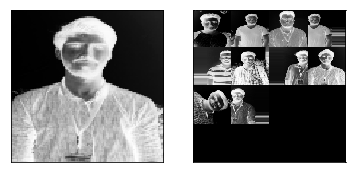

In [121]:
# Example of concat image visualization
pairs, targets = make_oneshot_task(10,Xtrain)
plot_oneshot_task(pairs)

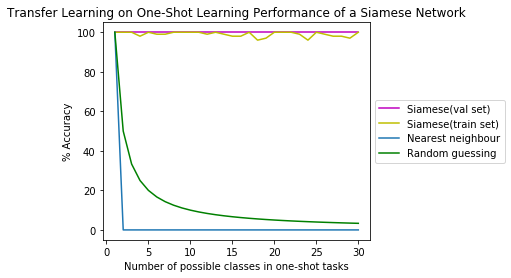

In [124]:
fig,ax = plt.subplots(1)
ax.plot(ways, val_accs, "m", label="Siamese(val set)")
ax.plot(ways, train_accs, "y", label="Siamese(train set)")
plt.plot(ways, nn_accs, label="Nearest neighbour")
ax.plot(ways, 100.0/ways, "g", label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("Transfer Learning on One-Shot Learning Performance of a Siamese Network")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()



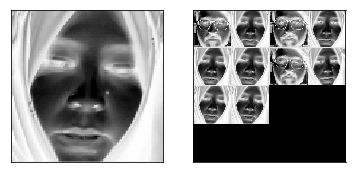

In [125]:
inputs,targets = make_oneshot_task(10, Xval)
plot_oneshot_task(inputs)

In [126]:
print(inputs[1].shape)
p=siamese.predict(inputs)
print(p)

(10, 1, 105, 105)
[[0.04531157]
 [0.3689271 ]
 [0.04022336]
 [0.2460612 ]
 [0.5043199 ]
 [0.20939055]
 [0.04654154]
 [0.1129894 ]
 [0.03349802]
 [0.11925972]]
